<a href="https://www.kaggle.com/code/pmykola/kp10-titanic?scriptVersionId=102633874" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### This is a notebook, which generates predictions for Titanic passenger survival competition.
It's accuracy is up to 0.79425, a top 5\% result.

### Outline:
0. Load libraries and custom functions.
1. Load data.
2. Preliminary data analysis: explore features and a target, delete unneeded features, create new features.
3. Train-test split.
4. Missing values. In some cases it may be useful to explore skew and perform log-transform before imputing missing values.
5. Feature engineering. Transform skewed variables, do OHC and scaling.
6. Fit models.
7. Evaluate models.
8. Feature importance, error analysis. Based on the results, go to 2. and iterate.
9. Make predictions.

### To do:
- Add EDA visualization.
- Add SHAP feature importances.
- Add Optuna XGBoost hyperparameter tuning.
- Add PR curve analysis.

In [34]:
# 0. Load libraries #

import numpy as np
import pandas as pd
import os, time, warnings, shap, optuna
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.svm import SVC
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, auc
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier

pd.set_option('display.max_columns', 20)
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.expand_frame_repr', False)
warnings.filterwarnings('ignore')

# Load custom pre-processing functions:

def draw_histograms(df, variables, n_rows, n_cols):
    # stolen from https://stackoverflow.com/questions/29530355/plotting-multiple-histograms-in-grid
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name+" Distribution")
    fig.tight_layout()  
    plt.show()


def fillna_mp_i1(df_train, df_test, df_pred, num_features, cat_features, num_fill='median', cat_fill='mode'):
    """This function speeds up filling missing values for 3 main datasets using different imputation methods.
    Later may replace it with some subclass.
    Example: fillna_mp_i1(X_train, X_test, X_pred, num_cols, cat_cols)"""
    # set df_pred to None if it does not exist
    if not ((cat_fill=='mode') and (num_fill=='median')):
        print ('Imputation method not Implemented yet!')
        return None
    
    df_train[num_features] = df_train[num_features].fillna(value=df_train[num_features].median())
    df_test[num_features] = df_test[num_features].fillna(value=df_train[num_features].median())
    df_train[cat_features] = df_train[cat_features].fillna(value=df_train[cat_features].mode().iloc[0])
    df_test[cat_features] = df_test[cat_features].fillna(value=df_train[cat_features].mode().iloc[0])
    if (df_pred is not None):
        df_pred[num_features] = df_pred[num_features].fillna(value=df_train[num_features].median())
        df_pred[cat_features] = df_pred[cat_features].fillna(value=df_train[cat_features].mode().iloc[0])
    df_train[num_features+cat_features].count
    
    all_good = (
    (np.prod(df_train[num_features+cat_features].shape)==df_train[num_features+cat_features].count().sum()) and 
    (np.prod(df_test[num_features+cat_features].shape) == df_test[num_features+cat_features].count().sum()) and 
    (np.prod(df_pred[num_features+cat_features].shape) == df_pred[num_features+cat_features].count().sum()))
    if (all_good):
        print('Missing values imputed successfully')
    else:
        print('There are still some missing values...')
    
def add_misDummy_mp_i1(df_train, df_test, df_pred, features):
    """This function creates new dummy columns for missing features.
    Example: add_misDummy_mp_i1(X_train, X_test, X_pred, ['Age'])"""
    # set df_pred to None if it does not exist
    for feature_name in features:
        misColName = 'mis'+feature_name
        df_train.loc[df_train[feature_name].isnull(), misColName]=1
        df_train.loc[df_train[feature_name].notnull(), misColName]=0
        df_test.loc[df_test[feature_name].isnull(), misColName]=1
        df_test.loc[df_test[feature_name].notnull(), misColName]=0
        if (df_pred is not None):
            df_pred.loc[df_pred[feature_name].isnull(), misColName]=1
            df_pred.loc[df_pred[feature_name].notnull(), misColName]=0
   

def discretize_mp_i1(df_train, df_test, df_pred, feature, ntiles, delete_feature=False):
    """This function divides a continuous feature into quantile groups.
    Example: discretize_mp_i1(X_train, X_test, X_pred, 'Age', 15)"""
    # set df_pred to None if it does not exist
    _,bin = pd.qcut(df_train[feature], ntiles, retbins = True, labels = False, duplicates = 'drop')
    df_train[feature+'Ntile'] = pd.cut(df_train[feature], labels=False, duplicates = 'drop', bins = bin ,include_lowest = True)
    df_test[feature+'Ntile'] = pd.cut(df_test[feature], labels=False, duplicates = 'drop', bins = bin ,include_lowest = True)
    if (df_pred is not None):
        df_pred[feature+'Ntile'] = pd.cut(df_pred[feature], labels=False, duplicates = 'drop', bins = bin ,include_lowest = True)
    if (delete_feature==True):
        df_train.drop(columns=[feature], inplace=True)
        df_test.drop(columns=[feature], inplace=True)
        df_pred.drop(columns=[feature], inplace=True)
    print('Discretized ',feature, ' into ', len(bin)-1, ' bins')


def log_transformer_mp_i1(df_train, df_test, df_pred, feature_subset=False, min_skew=3):
    """This function divides a continuous feature into quantile groups.
    Example: log_transformer_mp_i1(X_train, X_test, X_pred, feature_subset=num_cols)"""
    # set df_pred to None if it does not exist
    if (feature_subset==False):
        features_totransform = df_train.columns
    else:
        features_totransform = feature_subset.copy()
    skewed_vars = list(df_train.skew()[abs(df_train.skew())>min_skew].index)
    for col in list(set(skewed_vars)&set(features_totransform)):
        df_train[col] = np.log1p(df_train[col])
        df_test[col] = np.log1p(df_test[col])
        if (df_pred is not None):
            df_pred[col] = np.log1p(df_pred[col])
    print('Skewed columns log-transformed: ', list(set(skewed_vars)&set(features_totransform)))
    
    
# 1. Load data #

time0 = time.time()

path = '../input/titanic/train.csv'
df = pd.read_csv(path) 

df.drop(columns=['Name', 'Ticket', 'Cabin', 'PassengerId'],inplace=True)
pred=pd.read_csv('../input/titanic/test.csv')
pred0 = pred.copy()
pred.drop(columns=['Name', 'Ticket', 'Cabin', 'PassengerId'],inplace=True)

print(df.shape, pred.shape)
#df.head()

# 2. EDA, adding features #

#df.Survived.value_counts()
df['Age2'] = df['Age']**2
pred['Age2'] = pred['Age']**2

# 3. Train-test split #

train_y = df[['Survived']]
train_x = df.drop(columns = ['Survived'])
X_pred = pred.copy()

#bin_cols = [col for col in train_x.columns if train_x[col].nunique()==2]
cat_cols = [col for col in train_x.columns if train_x[col].nunique() in range(2,10)]
num_cols = list(set(train_x.columns)-set(cat_cols))

print('categorical features: ', cat_cols, 'numerical features: ', num_cols)

X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size = 0.1, random_state=101)
print(X_train.shape, X_test.shape, y_train.shape, X_pred.shape)

X_train.info()

# 4. Misisng values #

add_misDummy_mp_i1(X_train, X_test, X_pred, ['Age'])

fillna_mp_i1(X_train, X_test, X_pred, num_cols, cat_cols)
#[X_train.count(), X_test.count(), X_pred.count()]

# extra feature engineering (manual)

discretize_mp_i1(X_train, X_test, X_pred, 'Age', 15)
discretize_mp_i1(X_train, X_test, X_pred, 'SibSp', 30)
discretize_mp_i1(X_train, X_test, X_pred, 'Parch', 60)

cat_cols.extend(['misAge', 'AgeNtile', 'SibSpNtile', 'ParchNtile'])
cat_cols = list(set(cat_cols)-set(['SibSp', 'Parch']))


# 5.Feature engineering #

log_transformer_mp_i1(X_train, X_test, X_pred, feature_subset=num_cols)

# in general, if I plan using raw ols, I should drop one group. o/w, it is beteer to leabe all ohc groups.

feature_transformer = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore"), cat_cols),
    ])

X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
X_pred = pd.DataFrame(feature_transformer.transform(X_pred), columns=feature_transformer.get_feature_names_out())

fewfeatures = ['num__Age', 'num__Age2', 'num__Fare', 'cat__Sex_male', 'cat__Pclass_2', 'cat__Pclass_3']

X_train

# 6. Fit models #

lr = LogisticRegression()
param_grid = {'C':[0.3, 1, 3, 10, 30]}
lrm = GridSearchCV(lr, param_grid, cv=8)
lrm.fit(X_train, y_train)
print('Logistic ', lrm.best_params_, accuracy_score(y_train, lrm.predict(X_train)), roc_auc_score(y_train, lrm.predict(X_train)))

svm = SVC()
param_grid = {'C':[0.3, 1, 2, 3, 10]}
svmm = GridSearchCV(svm, param_grid, cv=8)
svmm.fit(X_train, y_train)
print('SVM ', svmm.best_params_, accuracy_score(y_train, svmm.predict(X_train)), roc_auc_score(y_train, svmm.predict(X_train)))

knn = KNeighborsClassifier()
param_grid = dict(n_neighbors=range(2,20))
knnm = GridSearchCV(knn, param_grid, cv=8)
knnm.fit(X_train[fewfeatures], y_train)
print('KNN ', knnm.best_params_, accuracy_score(y_train, knnm.predict(X_train[fewfeatures])), roc_auc_score(y_train, knnm.predict(X_train[fewfeatures])))

time1 = time.time()
rf = RandomForestClassifier()
param_grid = {'n_estimators':[100,200], 'max_depth':[2,4,6,8], 'max_features':[4,5,6]}
rfm = GridSearchCV(rf, param_grid, cv=4)
rfm.fit(X_train, y_train)
print('RF ', rfm.best_params_, accuracy_score(y_train, rfm.predict(X_train)), roc_auc_score(y_train, rfm.predict(X_train)), time.time()-time1)

time1 = time.time()
xgb = XGBClassifier()
# use 'gpu_hist' for more than 10,000 examples.
param_grid = {'n_estimators':[200], 'max_depth':[3,4], 'eta':[0.03, 0.04, 0.05], 'subsample':[0.6, 0.8],
             'colsample_bytree':[0.4, 0.6]}
xgbm = GridSearchCV(xgb, param_grid, cv=2)
xgbm.fit(X_train, y_train)
print('XGB ', xgbm.best_params_, accuracy_score(y_train, xgbm.predict(X_train)), roc_auc_score(y_train, xgbm.predict(X_train)), time.time()-time1)
print('XGB', f1_score(y_train,xgbm.predict(X_train)), recall_score(y_train,xgbm.predict(X_train)), precision_score(y_train,xgbm.predict(X_train)))

# 7. accuracy #

print('Out of Sample:')
print('Logistic ', accuracy_score(y_test, lrm.predict(X_test)), roc_auc_score(y_test, lrm.predict(X_test)))
print('SVM ', accuracy_score(y_test, svmm.predict(X_test)), roc_auc_score(y_test, svmm.predict(X_test)))
print('KNN ', accuracy_score(y_test, knnm.predict(X_test[fewfeatures])), roc_auc_score(y_test, knnm.predict(X_test[fewfeatures])))
print('RF ', accuracy_score(y_test, rfm.predict(X_test)), roc_auc_score(y_test, rfm.predict(X_test)))
print('XGB ', accuracy_score(y_test, xgbm.predict(X_test)), roc_auc_score(y_test, xgbm.predict(X_test)))
print('Total time ', time.time()-time0)

# VotingClassifier:

estimator = []
#estimator.append(('LR', LogisticRegression(C=1)))
estimator.append(('SVM', SVC(C=1, probability = True)))
#estimator.append(('KNN', KNeighborsClassifier(n_neighbors=5)))
estimator.append(('RF', RandomForestClassifier(max_depth=5, max_features=4, n_estimators=200)))
estimator.append(('XGB', XGBClassifier(eta=0.04, max_depth=3, n_estimators=200, 
                                       subsample=0.6, colsample_bytree=0.6)))
vot_soft = VotingClassifier(estimators = estimator, voting ='soft')
vot_soft.fit(X_train, y_train)
print('VotingClassifier5 ', accuracy_score(y_train, vot_soft.predict(X_train)), roc_auc_score(y_train, vot_soft.predict(X_train)))
print('VotingClassifier5 ', accuracy_score(y_test, vot_soft.predict(X_test)), roc_auc_score(y_test, vot_soft.predict(X_test)))
# to add KNN with different feature sets, 
# see https://stackoverflow.com/questions/45074579/votingclassifier-different-feature-sets

(891, 8) (418, 7)
categorical features:  ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked'] numerical features:  ['Age', 'Fare', 'Age2']
(801, 8) (90, 8) (801, 1) (418, 8)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 801 entries, 825 to 863
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    801 non-null    int64  
 1   Sex       801 non-null    object 
 2   Age       646 non-null    float64
 3   SibSp     801 non-null    int64  
 4   Parch     801 non-null    int64  
 5   Fare      801 non-null    float64
 6   Embarked  799 non-null    object 
 7   Age2      646 non-null    float64
dtypes: float64(3), int64(3), object(2)
memory usage: 56.3+ KB
Missing values imputed successfully
Discretized  Age  into  12  bins
Discretized  SibSp  into  4  bins
Discretized  Parch  into  4  bins
Skewed columns log-transformed:  ['Fare']
Logistic  {'C': 30} 0.815230961298377 0.7958368125969224
SVM  {'C': 1} 0.8414481897627965 0.8

In [35]:
# Optuna XGB hyperparameter optimization

time1=time.time()

### Fit XGBoost using Optuna hyperparameter optimization ###

def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1, scale_pos_weight=1, early_stopping_rounds=50):

    cv_regularizer=0.05
    # Usually values between 0.1 and 0.2 work fine.

    params = {
        #"tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        #"n_estimators": trial.suggest_int("n_estimators", 500, 1000),
        "n_estimators": 500,
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.01, 0.2),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.5, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 10.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 150.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
        "n_jobs": n_jobs,
    }
    # usually it makes sense to resrtict hyperparameter space from some solutions which Optuna will find
    # e.g., for tmx-joined data only (downsampled tmx), optuna keeps selecting depths of 2 and 3.
    # for my purposes (smooth left side of prc, close to 1), those solutions are no good.

    temp_out = []

    for i in range(cv_runs):

        X = X_train
        y = y_train.Survived

        model = XGBClassifier(**params)
        rkf = KFold(n_splits=n_splits, shuffle=True)
        X_values = X.values
        y_values = y.values
        y_pred = np.zeros_like(y_values)
        y_pred_train = np.zeros_like(y_values)
        for train_index, test_index in rkf.split(X_values):
            X_A, X_B = X_values[train_index, :], X_values[test_index, :]
            y_A, y_B = y_values[train_index], y_values[test_index]
            model.fit(X_A, y_A, eval_set=[(X_B, y_B)],
                      early_stopping_rounds=early_stopping_rounds, verbose = False)
            y_pred[test_index] += model.predict(X_B)
            y_pred_train[train_index] += model.predict(X_A)
        score_train = roc_auc_score(y_train, y_pred_train)
        score_test = roc_auc_score(y_train, y_pred) 
        overfit = score_train-score_test
        #return (score_test)
        #return (score_test-cv_regularizer*overfit)
        temp_out.append(score_test-cv_regularizer*overfit)

    return (np.mean(temp_out))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)
print('Total time for hypermarameter optimization ', time.time()-time1)
hp = study.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")

optuna_hyperpars = study.best_params
#optuna_hyperpars['tree_method']='gpu_hist'
optuna_hyperpars['scale_pos_weight']=1
#optuna_hyperpars['early_stopping_rounds']=50

optuna_xgb = XGBClassifier(**optuna_hyperpars)
optuna_xgb.fit(X_train, y_train)

display('Accuracy: ', accuracy_score(y_train,optuna_xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,optuna_xgb.predict(X_train)))
display('Recall score: ', recall_score(y_train,optuna_xgb.predict(X_train)))
display('Precision score: ', precision_score(y_train,optuna_xgb.predict(X_train)))
display('ROCAUC: ', roc_auc_score(y_train,optuna_xgb.predict(X_train)))
#display('Precision at 20% recall: ', r20prec_train)
#display('Precision at 50% recall: ', r50prec_train)
# Performance evaluation:
display('Accuracy: ', accuracy_score(y_test,optuna_xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,optuna_xgb.predict(X_test)))
display('Recall score: ', recall_score(y_test,optuna_xgb.predict(X_test)))
display('Precision score: ', precision_score(y_test,optuna_xgb.predict(X_test)))
display('ROCAUC: ', roc_auc_score(y_test,optuna_xgb.predict(X_test)))
#display('Precision at 20% recall: ', r20prec_test)
#display('Precision at 50% recall: ', r50prec_test)
display(time.time()-time0)


[I 2022-08-06 03:28:58,218] A new study created in memory with name: no-name-ca7b7172-7174-4c47-abe5-c2071be521a5
[I 2022-08-06 03:29:01,734] Trial 0 finished with value: 0.7778788421010775 and parameters: {'max_depth': 5, 'learning_rate': 0.0815425429614267, 'colsample_bytree': 0.8926308445210102, 'subsample': 0.5410456033654187, 'alpha': 0.5311995662872802, 'lambda': 15.531742063636118, 'gamma': 0.8980013097204437, 'min_child_weight': 0.776081586530493}. Best is trial 0 with value: 0.7778788421010775.
[I 2022-08-06 03:29:09,562] Trial 1 finished with value: 0.7549440335599826 and parameters: {'max_depth': 3, 'learning_rate': 0.16624798136154964, 'colsample_bytree': 0.6310383969296037, 'subsample': 0.6563948628868858, 'alpha': 8.38577585992445, 'lambda': 136.01313493450127, 'gamma': 7.733704092623301e-06, 'min_child_weight': 8.251884651429103}. Best is trial 0 with value: 0.7778788421010775.
[I 2022-08-06 03:29:11,803] Trial 2 finished with value: 0.7488438904131377 and parameters: {'

Total time for hypermarameter optimization  162.32875061035156
           max_depth : 4
       learning_rate : 0.0740337209996972
    colsample_bytree : 0.30513373313592596
           subsample : 0.6468124143278509
               alpha : 0.502111981980168
              lambda : 0.5400207533972782
               gamma : 4.485062247802197e-07
    min_child_weight : 2.8647627976570815
best objective value : 0.8135457672273252


'Accuracy: '

0.8651685393258427

'F1 score: '

0.8091872791519436

'Recall score: '

0.7557755775577558

'Precision score: '

0.870722433460076

'ROCAUC: '

0.8437512425941389

'Accuracy: '

0.8222222222222222

'F1 score: '

0.7714285714285716

'Recall score: '

0.6923076923076923

'Precision score: '

0.8709677419354839

'ROCAUC: '

0.8069381598793364

233.22073364257812

In [36]:
# 8. feature importance #

results = permutation_importance(xgbm, X_test, y_test, scoring='accuracy', n_jobs=-1)
fi_lr = pd.DataFrame({'col':X_test.columns, 'FI':results.importances_mean})
#fi_lr.sort_values('FI', ascending = False)

In [42]:
# 9. predictions #

submission_df_vc = pd.DataFrame({'PassengerId': pred0.PassengerId, 'Survived': vot_soft.predict(X_pred)}, columns=['PassengerId', 'Survived'])
submission_df_svm = pd.DataFrame({'PassengerId': pred0.PassengerId, 'Survived': svmm.predict(X_pred)}, columns=['PassengerId', 'Survived'])
submission_df_rf = pd.DataFrame({'PassengerId': pred0.PassengerId, 'Survived': rfm.predict(X_pred)}, columns=['PassengerId', 'Survived'])
submission_df_bt = pd.DataFrame({'PassengerId': pred0.PassengerId, 'Survived': xgbm.predict(X_pred)}, columns=['PassengerId', 'Survived'])
submission_df_oxgb = pd.DataFrame({'PassengerId': pred0.PassengerId, 'Survived': optuna_xgb.predict(X_pred)}, columns=['PassengerId', 'Survived'])

submission_df_vc.to_csv('KP10_v2_vc.csv',index=False)
submission_df_svm.to_csv('KP10_v2_svm.csv',index=False)
submission_df_rf.to_csv('KP10_v2_rf.csv',index=False)
submission_df_bt.to_csv('KP10_v2_bt.csv',index=False)
submission_df_oxgb.to_csv('KP10_oxgb.csv',index=False)

os.chdir(r'/kaggle/working')

from IPython.display import FileLink
FileLink(r'KP10_oxgb.csv')

#display(time.time()-time0)

/kaggle/working/KP10_oxgb.csv

### Appendix:
#### Exploring XGBoost predictions with PR curve

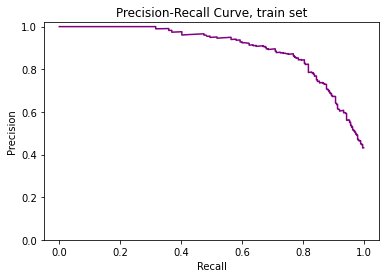

In [38]:
# Precision-Recall curve in train set
precision_t, recall_t, threshold = precision_recall_curve(y_train, xgbm.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]

fig, ax = plt.subplots()
ax.plot(recall_t, precision_t, color='purple')
ax.set_title('Precision-Recall Curve, train set')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()

In [39]:
display(xgbm.predict_proba(X_train)[:, 1])
display(precision_t, recall_t, threshold)

array([0.05759007, 0.4886744 , 0.90027773, 0.93964666, 0.6307373 ,
       0.9382993 , 0.7329252 , 0.10249637, 0.08693015, 0.7655485 ,
       0.16671105, 0.9346553 , 0.17283529, 0.30109835, 0.41348416,
       0.5972108 , 0.88914716, 0.89516747, 0.7759168 , 0.26943156,
       0.47939023, 0.503356  , 0.42110527, 0.07647451, 0.55135924,
       0.24154738, 0.9249877 , 0.1233901 , 0.2154063 , 0.64315015,
       0.3691497 , 0.08579125, 0.9049402 , 0.08543334, 0.22322124,
       0.13166068, 0.23616433, 0.11983263, 0.91860366, 0.25944772,
       0.9318084 , 0.62029004, 0.93532413, 0.0575145 , 0.1648358 ,
       0.07745197, 0.08448762, 0.04875061, 0.06085105, 0.8902183 ,
       0.12690584, 0.62490684, 0.14663342, 0.12256721, 0.46221793,
       0.09173054, 0.9606406 , 0.53678215, 0.07972509, 0.08552834,
       0.8007337 , 0.47672427, 0.4270591 , 0.06085105, 0.13214801,
       0.47273177, 0.59702176, 0.36317974, 0.89336455, 0.9736647 ,
       0.13044435, 0.06423449, 0.28757027, 0.07805303, 0.34894

array([0.43162393, 0.43081312, 0.43142857, 0.43204578, 0.43959243,
       0.44023324, 0.44152047, 0.44216691, 0.44281525, 0.44346549,
       0.44411765, 0.44542773, 0.44608567, 0.44674556, 0.44592593,
       0.44658754, 0.44725111, 0.4485842 , 0.44925373, 0.4505988 ,
       0.44977511, 0.45045045, 0.45112782, 0.45180723, 0.45317221,
       0.45385779, 0.45592705, 0.456621  , 0.45801527, 0.4587156 ,
       0.45941807, 0.4601227 , 0.46082949, 0.46153846, 0.46224961,
       0.46296296, 0.46367852, 0.46439628, 0.46428571, 0.46500778,
       0.46573209, 0.4648986 , 0.465625  , 0.46708464, 0.46855346,
       0.46929134, 0.47003155, 0.47077409, 0.46993671, 0.47068146,
       0.47142857, 0.47217806, 0.47292994, 0.47368421, 0.47444089,
       0.4752    , 0.47596154, 0.47672552, 0.47749196, 0.47826087,
       0.47903226, 0.47980614, 0.48136143, 0.48214286, 0.48292683,
       0.48371336, 0.48450245, 0.48529412, 0.48688525, 0.48768473,
       0.48848684, 0.4892916 , 0.49009901, 0.49090909, 0.49087

array([1.        , 0.99669967, 0.99669967, 0.99669967, 0.99669967,
       0.99669967, 0.99669967, 0.99669967, 0.99669967, 0.99669967,
       0.99669967, 0.99669967, 0.99669967, 0.99669967, 0.99339934,
       0.99339934, 0.99339934, 0.99339934, 0.99339934, 0.99339934,
       0.99009901, 0.99009901, 0.99009901, 0.99009901, 0.99009901,
       0.99009901, 0.99009901, 0.99009901, 0.99009901, 0.99009901,
       0.99009901, 0.99009901, 0.99009901, 0.99009901, 0.99009901,
       0.99009901, 0.99009901, 0.99009901, 0.98679868, 0.98679868,
       0.98679868, 0.98349835, 0.98349835, 0.98349835, 0.98349835,
       0.98349835, 0.98349835, 0.98349835, 0.98019802, 0.98019802,
       0.98019802, 0.98019802, 0.98019802, 0.98019802, 0.98019802,
       0.98019802, 0.98019802, 0.98019802, 0.98019802, 0.98019802,
       0.98019802, 0.98019802, 0.98019802, 0.98019802, 0.98019802,
       0.98019802, 0.98019802, 0.98019802, 0.98019802, 0.98019802,
       0.98019802, 0.98019802, 0.98019802, 0.98019802, 0.97689

array([0.08071651, 0.08101279, 0.08135831, 0.08213837, 0.08271927,
       0.08320058, 0.08346233, 0.08371118, 0.08425833, 0.08448762,
       0.08511243, 0.08533001, 0.08543334, 0.08552697, 0.08552834,
       0.08572456, 0.08579125, 0.08685369, 0.08693015, 0.08713038,
       0.08719107, 0.08720335, 0.08773568, 0.09012196, 0.09153106,
       0.09153768, 0.09160311, 0.09173054, 0.09200528, 0.09219795,
       0.09406153, 0.0944736 , 0.0947094 , 0.09526298, 0.09536333,
       0.09555266, 0.09629875, 0.09661717, 0.09664394, 0.09685775,
       0.09798431, 0.09798604, 0.09909042, 0.09911945, 0.09919723,
       0.09938587, 0.09956645, 0.09978406, 0.10015991, 0.10045106,
       0.10133231, 0.10204781, 0.10225426, 0.10249637, 0.10256679,
       0.10287374, 0.10290988, 0.10338216, 0.10383927, 0.10524745,
       0.10593569, 0.10598893, 0.10655218, 0.1066405 , 0.10769131,
       0.10815894, 0.10864446, 0.10926919, 0.11015971, 0.11060616,
       0.1112029 , 0.1119016 , 0.11218188, 0.11263213, 0.11322

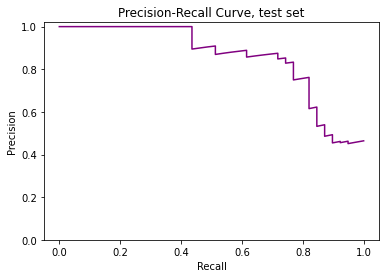

In [40]:
# Precision-Recall curve in test set
precision_t, recall_t, threshold = precision_recall_curve(y_test, xgbm.predict_proba(X_test)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.18)&(recall_t<0.22)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]

fig, ax = plt.subplots()
ax.plot(recall_t, precision_t, color='purple')
ax.set_title('Precision-Recall Curve, test set')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()

In [41]:
# for those examples, which the model is confident about, it could make sense to set predicted probability as 1.